# Автодополнение текстов

**Бизнес-контекст и задача проекта**<br>
Представьте, что вы работаете в соцсетевом приложении, где пользователи постят короткие тексты. В продукте стоит задача — добавить возможность автодополнения текстов. Разработчики просят вас создать модель, которую можно запускать на мобильных устройствах. Для смартфонов есть значительные требования по оперативной памяти и скорости работы, так что важна легковесность модели.

**Формальная задача**<br>
Представьте, что разработчики предоставили вам датасет с короткими текстовыми постами. 
Поэтапное описание задачи:
Взять датасет от разработчиков, очистить его, подготовить для обучения модели.
Реализовать и обучить модель на основе рекуррентных нейронных сетей.
Замерить качество разработанной и обученной модели.
Взять более «тяжёлую» предобученную модель из Transformers и замерить её качество.
Проанализировать результаты и дать рекомендации разработчикам: стоит ли использовать лёгкую модель или лучше постараться поработать с ограничениями по памяти и использовать большую предобученную.

**Содержание**

0. [Подготовка](#step_0)
1. [Сбор и подготовка данных](#step_1)
2. [Реализация рекуррентной сети](#step_2)
3. [Тренировка модели](#step_3)
4. [Использование предобученного трансформера](#step_4)
5. [Выводы](#step_5)

<a id='step_0'></a>
## 0. Подготовка

Задание:
1. Подготовьте окружение. Используйте файл requirements_sprint_2_project.txt.
2. Создайте git-репозиторий. Подумайте над структурой проекта. Можете заранее создать некоторые файлы, в которых будете писать код.

In [1]:
kaggle_test = False

In [ ]:
if kaggle_test:
    import sys
    sys.path.append('/kaggle/input/datasets/.../')

    !pip install -q evaluate
else:
    %load_ext autoreload
    %autoreload 2

In [3]:
from pathlib import Path

import pandas as pd

import torch
from torch import nn
from torch.utils.data import DataLoader

from transformers import AutoTokenizer

from sklearn.model_selection import train_test_split

# Обработка датасета
from src.data_utils import (
    read_raw_dataset,
    process_dataset
)

# Подготовка датасетов
from src.next_token_dataset import NextTokenDataset, collate_fn

# LSTM модель
# from src.lstm_model import LSTMAutocompleteModel
import src.lstm_model as lstm_model

# Обучение модели
# from src.lstm_train import train_lstm_model
import src.lstm_train as lstm_train


from src.eval_transformer_pipeline import create_distilgpt2_generator, evaluate_transformer_rouge

/home/ubuntu/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
RAND_SEED = 42

<a id='step_1'></a>
## 1. Сбор и подготовка данных

Задание:
1. Скачайте датасет, положите его в папку data.
2. «Почистите» тексты в датасете, а затем токенизируйте их. Для удобства можете сохранить почищенный и токенизированный датасет.
3. Разбейте датасет на трейн, валидацию и тест.
4. Создайте torch.Dataset и torch.DataLoader для обучения модели.

Определим путь до директории с данными.

In [ ]:
if kaggle_test:
    DATA_DIR = Path('/kaggle/input/datasets/...')
else:
    DATA_DIR = Path('data')

RAW_PATH = DATA_DIR/'raw_dataset.csv'

Читаем сырой датасет.

In [6]:
raw_df = read_raw_dataset(RAW_PATH)
raw_df.head()

,raw_text
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,is upset that he can't update his Facebook by ...
2,@Kenichan I dived many times for the ball. Man...
3,my whole body feels itchy and like its on fire
4,"@nationwideclass no, it's not behaving at all...."


In [7]:
processed_df = process_dataset(raw_df)
processed_df.head()

,raw_text,clean_text
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...","- awww, that's a bummer. you shoulda got david..."
1,is upset that he can't update his Facebook by ...,is upset that he can't update his facebook by ...
2,@Kenichan I dived many times for the ball. Man...,i dived many times for the ball. managed to sa...
3,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire
4,"@nationwideclass no, it's not behaving at all....","no, it's not behaving at all. i'm mad. why am ..."


Разбиваем датасет на обучающую, валидационную и тестовую выборки. Проверяем, объем данных в каждом датасете.

In [8]:
train_df, val_test_df = train_test_split(processed_df, test_size=0.2, random_state=RAND_SEED)
val_df, test_df = train_test_split(val_test_df, test_size=0.5, random_state=RAND_SEED)

train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

print(f'raw: {len(raw_df)}')
print(f'processed: {len(processed_df)}')
print(f'train: {len(train_df)}, val: {len(val_df)}, test: {len(test_df)}')

raw: 139852
processed: 136026
train: 108820, val: 13603, test: 13603


Сохраняем выборки

In [9]:
if kaggle_test:
    OUTPUT_DIR = Path('/kaggle/working/')
    processed_df.to_csv(OUTPUT_DIR/'processed_df.csv', encoding='utf-8')
    train_df.to_csv(OUTPUT_DIR/'train_df.csv', encoding='utf-8')
    val_df.to_csv(OUTPUT_DIR/'val_df.csv', encoding='utf-8')
    test_df.to_csv(OUTPUT_DIR/'test_df.csv', encoding='utf-8')
else:
    processed_df.to_csv(DATA_DIR/'processed_df.csv', encoding='utf-8')
    train_df.to_csv(DATA_DIR/'train_df.csv', encoding='utf-8')
    val_df.to_csv(DATA_DIR/'val_df.csv', encoding='utf-8')
    test_df.to_csv(DATA_DIR/'test_df.csv', encoding='utf-8')

In [10]:
model_name = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [11]:
batch_size = 128

In [12]:
train_texts = train_df['clean_text'].tolist()
val_texts = val_df['clean_text'].tolist()
test_texts = test_df['clean_text'].tolist()

In [13]:
train_dataset = NextTokenDataset(train_texts, tokenizer)
val_dataset = NextTokenDataset(val_texts, tokenizer)
test_dataset = NextTokenDataset(test_texts, tokenizer)

In [14]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

In [15]:
print(f'Количество батчей в train_dataloader: {len(train_dataloader)}')
print(f'Количество батчей в val_dataloader: {len(val_dataloader)}')
print(f'Количество батчей в test_dataloader: {len(test_dataloader)}')

Количество батчей в train_dataloader: 851
Количество батчей в val_dataloader: 107
Количество батчей в test_dataloader: 107


In [16]:
batch = next(iter(train_dataloader))
print('input_ids shape:', tuple(batch['input_ids'].shape))
print('labels shape:', tuple(batch['labels'].shape))

input_ids shape: (128, 63)
labels shape: (128, 63)


In [17]:
batch

{'input_ids': tensor([[ 2125,  1016,  4487,  ...,     0,     0,     0],
         [ 1045,  2514,  2066,  ...,     0,     0,     0],
         [ 2001, 17704,  5327,  ...,     0,     0,     0],
         ...,
         [ 2166, 10514,  2595,  ...,     0,     0,     0],
         [22635,  4653,  2908,  ...,     0,     0,     0],
         [10201,  2091,  1012,  ...,     0,     0,     0]]),
 'labels': tensor([[ 1016,  4487,  2100,  ...,  -100,  -100,  -100],
         [ 2514,  2066,  2941,  ...,  -100,  -100,  -100],
         [17704,  5327,  2005,  ...,  -100,  -100,  -100],
         ...,
         [10514,  2595,  2613,  ...,  -100,  -100,  -100],
         [ 4653,  2908,  2085,  ...,  -100,  -100,  -100],
         [ 2091,  1012,  1012,  ...,  -100,  -100,  -100]]),
 'lengths': tensor([ 9, 16, 18, 14, 17,  3, 16, 22, 31,  5, 10, 27, 27, 31, 10,  9, 25, 11,
         27, 63, 17, 19,  8,  5, 30, 12, 10, 13, 16, 30, 22,  7, 19, 18, 10, 19,
         17,  7,  6, 13, 10, 10, 18, 22, 14,  9, 21, 13, 27, 34,

<a id='step_2'></a>
## Этап 2. Реализация рекуррентной сети

Задание:
1. Напишите код модели на основе LSTM. В методе forward модель должна принимать на вход последовательность токенов и предсказывать следующий токен.
2. Дополнительно для модели реализуйте метод генерации нескольких токенов.

Создание модели на основе LSTM

In [18]:
model = lstm_model.LSTMAutocompleteModel(
    vocab_size=tokenizer.vocab_size,
    embedding_dim=256,
    hidden_dim=128,
    num_layers=2,
    dropout=0.2,
    pad_token_id=tokenizer.pad_token_id,
)

<a id='step_3'></a>
## 3. Тренировка модели

Задание:
1. Напишите код замера и вывода метрики ROUGE. В коде модель должна проходиться по DataLoader'у и генерировать автодополнения, которые затем будут сравниваться с таргетом. 
Для простоты реализуйте сценарий, где в качестве входа модель получает 3/4 исходного текста и старается дополнить оставшиеся 1/4.
2. Напишите код тренировки модели, во время тренировки выводите значения функции потерь и метрики ROUGE.
3. Обучите модель, подобрав оптимальные параметры. Во время тренировки или после неё выведите некоторые примеры автодополнений, которые выучила модель. Ориентировочное время тренировки: несколько минут на одну эпоху при размере батча около 256 и размерности скрытого слоя LSTM около 128. Так как тексты ограничены по длине, а памяти на видеокарте хватает с запасом, то можно ставить размер батча и размерности модели и побольше.

Определяем, где будем запускать обучение

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

Создание оптимизатора и функции потерь

In [20]:
lr = 1e-3
weight_decay = 1e-5

optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss(ignore_index=-100)

Обучаем модель

In [21]:
train_history = lstm_train.train_lstm_model(
    model=model,
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    tokenizer=tokenizer,
    optimizer=optimizer,
    criterion=criterion,
    num_epochs=10,
    device=device,
    print_examples=3,
)

  0%|          | 0/10 [00:00<?, ?it/s]

prefix: has a ache in her head it ' s just getting worse and
target: won ' t go away
pred  : .....
------------------------------------------------------------
prefix: i wish heidi would tweet me. she ' s
target: my role model.
pred  : to to to to
------------------------------------------------------------
prefix: say some tehil
target: ##im.
pred  : ..
------------------------------------------------------------


 10%|█         | 1/10 [02:04<18:37, 124.17s/it]

epoch 1/10 | train_loss=6.5551 | val_loss=6.2999 | rouge1=0.0078 | rouge2=0.0000
prefix: has a ache in her head it ' s just getting worse and
target: won ' t go away
pred  : i ' t be a
------------------------------------------------------------
prefix: i wish heidi would tweet me. she ' s
target: my role model.
pred  : a day..
------------------------------------------------------------
prefix: say some tehil
target: ##im.
pred  : ..
------------------------------------------------------------


 20%|██        | 2/10 [04:08<16:35, 124.42s/it]

epoch 2/10 | train_loss=5.9420 | val_loss=5.6362 | rouge1=0.0428 | rouge2=0.0016
prefix: has a ache in her head it ' s just getting worse and
target: won ' t go away
pred  : i ' m so sad
------------------------------------------------------------
prefix: i wish heidi would tweet me. she ' s
target: my role model.
pred  : a good day.
------------------------------------------------------------
prefix: say some tehil
target: ##im.
pred  : ..
------------------------------------------------------------


 30%|███       | 3/10 [06:13<14:31, 124.56s/it]

epoch 3/10 | train_loss=5.4447 | val_loss=5.2897 | rouge1=0.0524 | rouge2=0.0040
prefix: has a ache in her head it ' s just getting worse and
target: won ' t go away
pred  : i ' m so sad
------------------------------------------------------------
prefix: i wish heidi would tweet me. she ' s
target: my role model.
pred  : not a good day
------------------------------------------------------------
prefix: say some tehil
target: ##im.
pred  : ##s is
------------------------------------------------------------


 40%|████      | 4/10 [08:18<12:28, 124.72s/it]

epoch 4/10 | train_loss=5.1921 | val_loss=5.1205 | rouge1=0.0597 | rouge2=0.0059
prefix: has a ache in her head it ' s just getting worse and
target: won ' t go away
pred  : i ' m so sad
------------------------------------------------------------
prefix: i wish heidi would tweet me. she ' s
target: my role model.
pred  : not a good day
------------------------------------------------------------
prefix: say some tehil
target: ##im.
pred  : ##s.
------------------------------------------------------------


 50%|█████     | 5/10 [10:23<10:23, 124.70s/it]

epoch 5/10 | train_loss=5.0384 | val_loss=5.0064 | rouge1=0.0653 | rouge2=0.0074
prefix: has a ache in her head it ' s just getting worse and
target: won ' t go away
pred  : i ' m so sad
------------------------------------------------------------
prefix: i wish heidi would tweet me. she ' s
target: my role model.
pred  : not a good day
------------------------------------------------------------
prefix: say some tehil
target: ##im.
pred  : ##s.
------------------------------------------------------------


 60%|██████    | 6/10 [12:27<08:18, 124.64s/it]

epoch 6/10 | train_loss=4.9253 | val_loss=4.9262 | rouge1=0.0705 | rouge2=0.0081
prefix: has a ache in her head it ' s just getting worse and
target: won ' t go away
pred  : i ' m so sad
------------------------------------------------------------
prefix: i wish heidi would tweet me. she ' s
target: my role model.
pred  : not a good day
------------------------------------------------------------
prefix: say some tehil
target: ##im.
pred  : ##s.
------------------------------------------------------------


 70%|███████   | 7/10 [14:32<06:14, 124.85s/it]

epoch 7/10 | train_loss=4.8353 | val_loss=4.8680 | rouge1=0.0734 | rouge2=0.0094
prefix: has a ache in her head it ' s just getting worse and
target: won ' t go away
pred  : i ' m not going
------------------------------------------------------------
prefix: i wish heidi would tweet me. she ' s
target: my role model.
pred  : not a good day
------------------------------------------------------------
prefix: say some tehil
target: ##im.
pred  : ##s.
------------------------------------------------------------


 80%|████████  | 8/10 [16:37<04:09, 124.72s/it]

epoch 8/10 | train_loss=4.7624 | val_loss=4.8223 | rouge1=0.0775 | rouge2=0.0099
prefix: has a ache in her head it ' s just getting worse and
target: won ' t go away
pred  : i ' m not feeling
------------------------------------------------------------
prefix: i wish heidi would tweet me. she ' s
target: my role model.
pred  : not a good day
------------------------------------------------------------
prefix: say some tehil
target: ##im.
pred  : ##s are
------------------------------------------------------------


 90%|█████████ | 9/10 [18:41<02:04, 124.65s/it]

epoch 9/10 | train_loss=4.6991 | val_loss=4.7871 | rouge1=0.0802 | rouge2=0.0107
prefix: has a ache in her head it ' s just getting worse and
target: won ' t go away
pred  : i ' m not going
------------------------------------------------------------
prefix: i wish heidi would tweet me. she ' s
target: my role model.
pred  : not a good day
------------------------------------------------------------
prefix: say some tehil
target: ##im.
pred  : ##x is
------------------------------------------------------------


100%|██████████| 10/10 [20:46<00:00, 124.69s/it]

epoch 10/10 | train_loss=4.6454 | val_loss=4.7614 | rouge1=0.0826 | rouge2=0.0117


In [22]:
train_history_df = pd.DataFrame(train_history)
train_history_df

,epoch,train_loss,val_loss,rouge1,rouge2
0,1,6.555146,6.299944,0.007788,0.000000
1,2,5.942040,5.636206,0.042810,0.001563
2,3,5.444687,5.289710,0.052379,0.003956
3,4,5.192150,5.120538,0.059748,0.005876
4,5,5.038396,5.006382,0.065313,0.007446
5,6,4.925259,4.926153,0.070544,0.008112
6,7,4.835317,4.867975,0.073352,0.009350
7,8,4.762356,4.822325,0.077491,0.009949
8,9,4.699124,4.787121,0.080215,0.010695
9,10,4.645407,4.761427,0.082553,0.011727


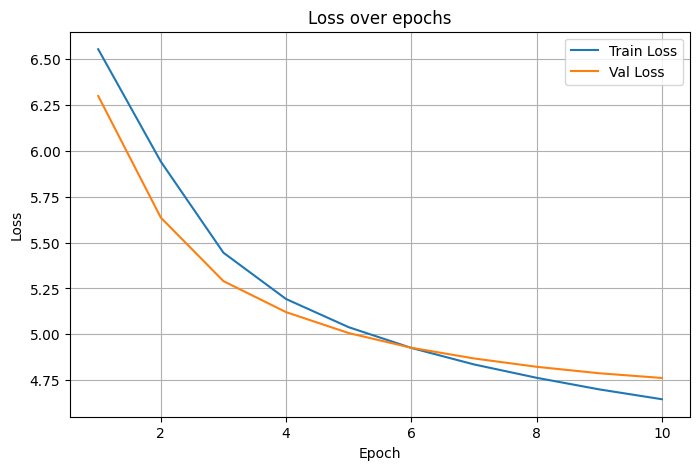

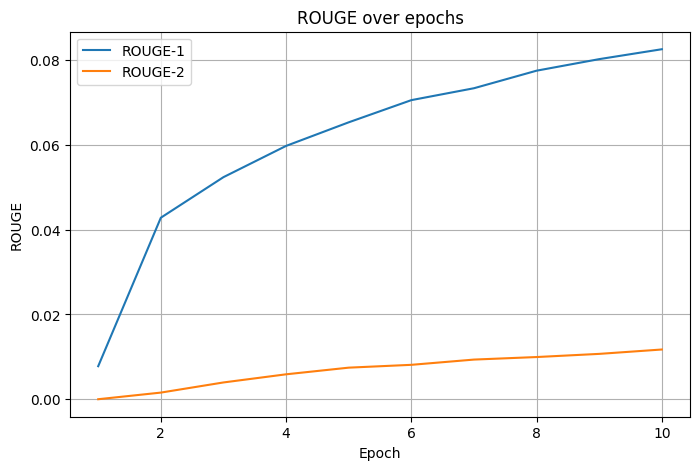

In [23]:
lstm_train.plot_training_history(train_history_df)

Сохраним веса обученной модели

In [24]:
torch.save(model.state_dict(), 'models/lstm_model_weights.pt')

Посмотрим на качество на тестовой выборке

In [25]:
lstm_rouge_test_scores = lstm_train.evaluate_lstm_rouge(
    model=model, 
    loader=test_dataloader,
    tokenizer=tokenizer,
    device=device,
    print_examples=3
)

prefix: gotta go to class
target: now.
pred  : ..
------------------------------------------------------------
prefix: anyone who reaches me via my cell - right now, i don ' t know where it is think it ' s in my dd ' s car
target: so i ' m not being rude not answering!
pred  : ..........
------------------------------------------------------------
prefix: finally can hit the hay. two hour nap and off to the airport. ugh...
target: and still no ticket for tom night
pred  : .......
------------------------------------------------------------


In [26]:
print(
    f'rouge1={lstm_rouge_test_scores["rouge1"]:.4f} | '
    f'rouge2={lstm_rouge_test_scores["rouge2"]:.4f}'
)

rouge1=0.0840 | rouge2=0.0128


<a id='step_4'></a>
## 4. Использование предобученного трансформера

Задание:
1. Воспользуйтесь моделью трансформера distilgpt2 из Transformers и дополните тексты из датасета.
2. Напишите код замера и вывода метрики ROUGE, но уже с использованием трансформера. Здесь, как и с LSTM, предсказывайте последнюю четверть текста.
3. Подберите параметры генерации, замерьте качество модели на валидационной выборке, выведите примеры предсказаний.

In [27]:
# инициализируем предобученный трансформер distilgpt2
transformer_generator, transformer_tokenizer = create_distilgpt2_generator('distilgpt2', device)

# оцениваем качество дополнения последней четверти текста на тесте
transformer_rouge_test_scores = evaluate_transformer_rouge(
    generator=transformer_generator,
    tokenizer=transformer_tokenizer,
    texts=test_texts,
    print_examples=3,
    do_sample=True,
    top_k=50
)

Device set to use cuda


prefix: gotta go to
target: class now.
pred  : their local hospital
------------------------------------------------------------
prefix: anyone who reaches me via my cell - right now, i don't know where it is think it's in my dd's
target: car so i'm not being rude not answering!
pred  : mind.
------------------------------------------------------------
prefix: finally can hit the hay. two hour nap and off to the airport. ugh...and still
target: no ticket for tom night
pred  : there was an error,
------------------------------------------------------------
rouge1=0.0507 | rouge2=0.0045


<a id='step_5'></a>
## 5. Формулирование выводов

Задание:
1. Сравните примеры предсказаний двух моделей, а также получившиеся метрики.
2. Сделайте выводы о том, какую модель лучше использовать и почему.

Посмотрим на качество нашей модели

In [28]:
print(
    f'ROUGE-1 = {lstm_rouge_test_scores["rouge1"]:.4f} | '
    f'ROUGE-2 = {lstm_rouge_test_scores["rouge2"]:.4f}'
)

ROUGE-1 = 0.0840 | ROUGE-2 = 0.0128


Посмотрим на качество трансформера

In [29]:

print(
    f'ROUGE-1 = {transformer_rouge_test_scores["rouge1"]:.4f} | '
    f'ROUGE-2 = {transformer_rouge_test_scores["rouge2"]:.4f}'
)

ROUGE-1 = 0.0507 | ROUGE-2 = 0.0045


**Выводы:**
1. По метрикам видно, что самостоятельно обученная модель LSTM лучше предобученного трансформера distilgpt2.
    * По `ROUGE-1` (LSTM vs distilgpt2): 0.0840 vs 0.0507
    * По `ROUGE-2` (LSTM vs distilgpt2): 0.0128 vs 0.0045
2. По примерам предсказаний на тестовой выборке distilgpt2 показывает себя лучше обученной LSTM модели. Все-таки он генерирует хоть что-то.<br>
Тут скорее всего дело в очень коротком обучении модели LSTM. На валидационных примерах видно, что модель может генерировать что-то осмысленное. Кажется, что если дать больше времени на обучение, то она справится и с тестовой выборкой/
3. Качество LSTM модели существенно выше качества трансформера. Это означает, что хоть и на выведенных примерах она не очень, но на остальных предложениях, она предсказывает достаточно неплохо. С учетом того, что нам нужна легковесная модель, стоит выбрать LSTM. 